# Simulated annealing & Traveling Salesman problem

Simulated annealing is a technique which uses Matropolis to find a global minimum of a
function of many variables. It is typically used for large scale problems, especially ones where a desired global minimum is hidden among many poorer local minima.

The class of problems known as NP-complete problems, whose computation time for an exact solution increases with N as $\exp(const.× N)$, were basically unsolvable until recently.

Only in 1983, the method was invented ( Kirkpatrick, S., Gelatt, C.D., and Vecchi, M.P. 1983, Science, vol. \textbf{220}, 671-680 (1083).) which effectively solved most of these problems for practical purposes.

Simulated annealing does not "solve" them exactly, but in most cases we just need reasonable good solution even if its not the one with exacly the lowest total energy.

The archtype example of NP-complete problems, the traveling salesman problem, is easy to solve with this method.

Other very important application is in designing complex integrated circuits: The arrangement of several hundred thousand circuit elements on a tiny silicon substrate is optimized so as to minimize interference among their connecting wires.


The simulated annealing uses Metropolis algorithm with slowly decreasing temperature in order that system relaxes into its "ground state".

The steps consis of
- Pick initial configuration $X$ and an initial temperature
  $T_0$. $T_0$ should be much higher than the changes in function $f$
  to be minimized when typical Monte Carlo step is taken.
- Loop through decreasing temperature $T_i$

  - Equilibrate at $T_i$ using Metropolis with selected, allowed
  elementary changes in the system. The system is equilibrated when
  the rate of change of $f$ averaged over some number of Monte Carlo
  steps is small.
  - Measure the termal average of $f$. If $f$ does not decrease at
  this temperature $T_i$ compared to previous temperature $T_{i-1}$,
  exit the loop.
  - Decrease $T_i$ to $T_{i+1}$. For example, reduces the effective temperature by 10\%.


The major difficulty (art) in implementation of the algorithm is that
there is no obvious analogy for the temperature T with respect to a
free parameter in the combinatorial problem. Furthermore, avoidance of
entrainment in local minima (quenching) is dependent on the "annealing
schedule", the choice of initial temperature, how many iterations are
performed at each temperature, and how much the temperature is
decremented at each step as cooling proceeds.


## The Traveling Salesman problem

The seller visits $N$ cities ($i=0...N-1$) with given positions
$R_i$, returning finally to his or her city of origin. 
**Each city** is to be **visited only once**, and the **route** is to be made **as
short as possible**. This problem belongs to a class known as
*NP-complete* problems, whose computation time for an exact solution
increases with N exponentially.

The traveling salesman problem also belongs to a class of minimization
problems for which the objective function E has many local minima. In
practical cases, it is often enough to be able to choose from these a
minimum which, even if not absolute, cannot be significantly improved
upon.

The annealing method manages to achieve this, while limiting its
calculations to scale as a small power of $N$.


As a problem in simulated annealing, the traveling salesman problem is handled
as follows:

- 1 **Configuration:** The cities are numbered $i = 0. . .N-1$ and each has coordinate $R_i$. A configuration is a permutation of the number $0 ...N-1$, interpreted as the order in which the cities are visited.
- 2 **Rearrangements:** An efficient set of moves are:
    - **(a)** A section of path is removed and then replaced with the same cities running in   the opposite order; or
    - **(b)** A section of path is removed and then replaced in between two cities on another, randomly chosen, part of the path.

- 3 **Objective Function:** In the simplest form of the problem, $E$ is taken just as the total length of journey


The above two mentioned moves are hardest to implement.  The following
plot explains them by an example

<img src="reverse.pdf" width="60%">
<img src="transportn.pdf" width="60%">

For details of implementation, check the example source code.


In [16]:
import scipy as scp
from numpy import random
from numpy import linalg
from numba import jit

ncity=100

# random coordinates in 2D for n-cities
R = random.random((ncity,2)) # completely randomly positioned cities
city = range(ncity)          # we are visiting them in order in the array

In [3]:
def Distance(R1,R2):
    return linalg.norm(R1-R2) # sqrt(x^2+y^2)

def TotalDistance(city, R):
    dist=0
    for i in range(len(city)-1):
        dist += Distance(R[city[i]],R[city[i+1]])
    dist += Distance(R[city[-1]],R[city[0]])
    return dist

In [17]:
def Plot(city, R, dist):
    Pt = [R[city[i]] for i in range(len(city))] # list of [(x_i,y_i),...] coordinates
    Pt += [R[city[0]]]   # add the very last/first city so that the curve is connected to itself
    Pt = array(Pt)
    title('Total distance='+str(dist))
    plot(Pt[:,0],Pt[:,1],'o-')
    show()

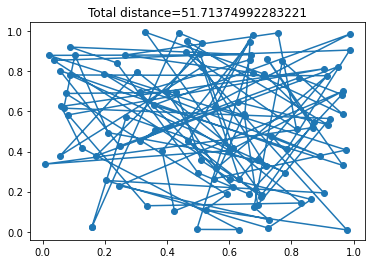

In [18]:
from pylab import *
%matplotlib inline
Plot(city,R, TotalDistance(city,R))

In [19]:
@jit(nopython=True)
def FindASegment(R):
    nct = len(R) # number of cities
    while True:
        # Two cities n[0] and n[1] chosen at random
        n0 = int(nct*rand())
        n1 = int((nct-1)*rand())
        if n1>=n0 : n1 +=1
        if n1<n0 : (n0,n1) = (n1,n0) # always make sure that n1>n0
        nn = (nct-(n1-n0+1))         # the rest of the cities
        if nn>=3 : break             # the rest is big enough
    n2 = (n0-1) % nct        # the city before first
    n3 = (n1+1) % nct        # the city past second
    return (n0,n1,n2,n3)

In [20]:
def CostReverse(R, city, n0, n1, n2, n3):
    # cost for reverse move
    de = Distance(R[city[n2]],R[city[n1]])+Distance(R[city[n0]],R[city[n3]])
    de-= Distance(R[city[n2]],R[city[n0]])+Distance(R[city[n1]],R[city[n3]])
    return de

def Reverse(R, city, n0, n1, n2, n3):
    newcity = copy(city)
    for j in range(n1-n0+1):
        newcity[n0+j] = city[n1-j]
    return newcity

In [21]:
@jit(nopython=True)
def FindTSegment(R):
    (n0,n1,n2,n3) = FindASegment(R)
    nct = len(R)
    nn = nct - (n1-n0+1)  # number for the rest of the cities
    n4 = (n1+1 + int(rand()*(nn-1)) ) % nct # city on the rest of the path
    n5 = (n4+1) % nct
    return (n0,n1,n2,n3,n4,n5)

In [22]:
def CostTranspose(R, city, n0,n1,n2,n3,n4,n5):
    de = -Distance(R[city[n1]], R[city[n3]])
    de-= Distance(R[city[n0]], R[city[n2]])
    de-= Distance(R[city[n4]], R[city[n5]])
    de+= Distance(R[city[n0]], R[city[n4]])
    de+= Distance(R[city[n1]], R[city[n5]])
    de+= Distance(R[city[n2]], R[city[n3]])
    return de


def Transpose(R, city, n0,n1,n2,n3,n4,n5):
    nct = len(R)
    newcity = []
    # Segment in the range n0,...n1
    for j in range(n1-n0+1):
        newcity.append( city[ (j+n0)%nct ] )
    # is followed by segment n5...n2
    for j in range( (n2-n5)%nct + 1):
        newcity.append( city[ (j+n5)%nct ] )
    # is followed by segement n3..n4
    for j in range( (n4-n3)%nct + 1):
        newcity.append( city[ (j+n3)%nct ] )
    return newcity

In [25]:
nn = FindTSegment(R)
de = CostTranspose(R, city, *nn) # *nn = nn[0],nn[1],nn[2],nn[3],nn[4],nn[5], i.e., unpacking the list
print(nn)
print(de)
r1 = Transpose(R, city, *nn)
print(r1)

(59, 99, 58, 0, 9, 10)
-0.27299853286681464
[59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [26]:
def TravelingSalesman(city, R, maxSteps, maxAccepted, Tstart, fCool, maxTsteps, Preverse=0.5):
    T = Tstart
    dist = TotalDistance(city,R)
    for t in range(maxTsteps):
        accepted = 0
        for i in range(maxSteps):
            if Preverse > rand():
                # Try reverse
                nn = FindASegment(R)
                de = CostReverse(R, city, *nn)
                if de < 0 or exp(-de/T) > rand():
                    accepted += 1
                    dist += de
                    city = Reverse(R, city, *nn)
            else: 
                # here we transpose
                nn = FindTSegment(R)
                de = CostTranspose(R, city, *nn)
                if de < 0 or exp(-de/T) > rand():
                    accepted += 1
                    dist += de
                    city = Transpose(R, city, *nn)
            if accepted > maxAccepted: 
                break    
        T *= fCool
        Plot(city, R, dist)
        print("T=%10.5f , distance=%10.5f acc.steps=%d" % (T, dist,accepted))
        if accepted == 0:
            break
    Plot(city, R, dist)
    return city 

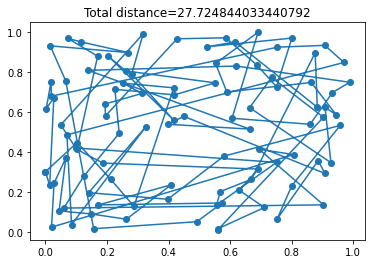

T=   0.18000 , distance=  27.72484 acc.steps=1001


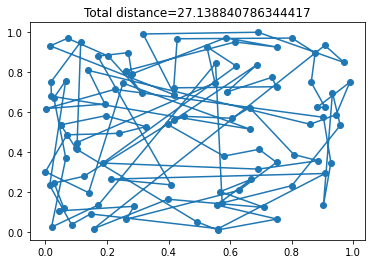

T=   0.16200 , distance=  27.13884 acc.steps=1001


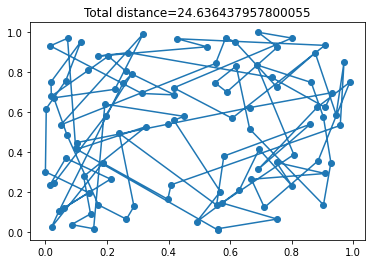

T=   0.14580 , distance=  24.63644 acc.steps=1001


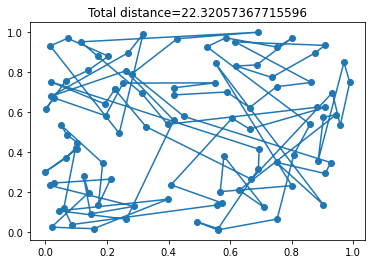

T=   0.13122 , distance=  22.32057 acc.steps=1001


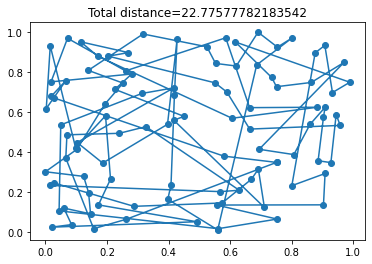

T=   0.11810 , distance=  22.77578 acc.steps=1001


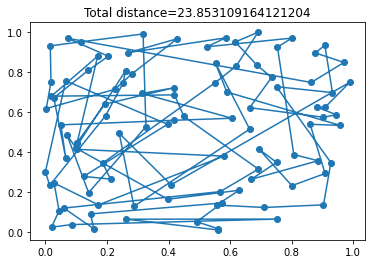

T=   0.10629 , distance=  23.85311 acc.steps=1001


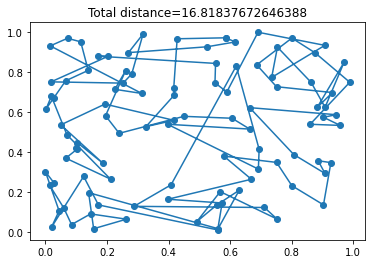

T=   0.09566 , distance=  16.81838 acc.steps=722


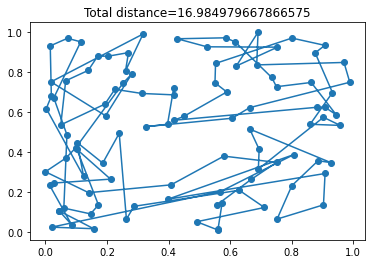

T=   0.08609 , distance=  16.98498 acc.steps=507


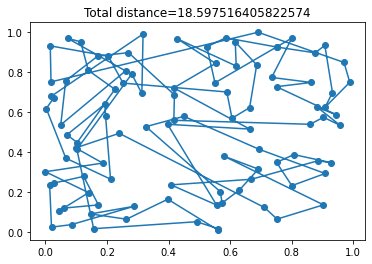

T=   0.07748 , distance=  18.59752 acc.steps=456


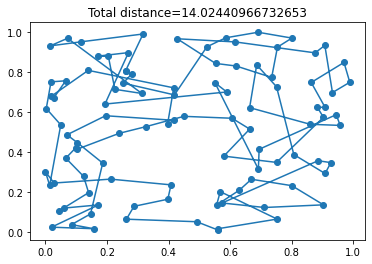

T=   0.06974 , distance=  14.02441 acc.steps=445


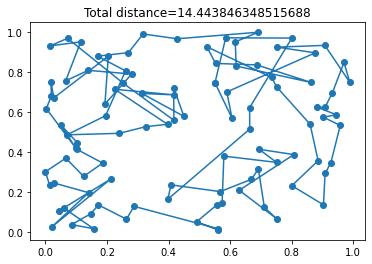

T=   0.06276 , distance=  14.44385 acc.steps=308


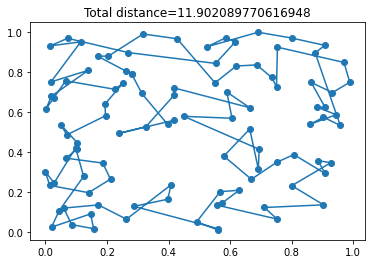

T=   0.05649 , distance=  11.90209 acc.steps=290


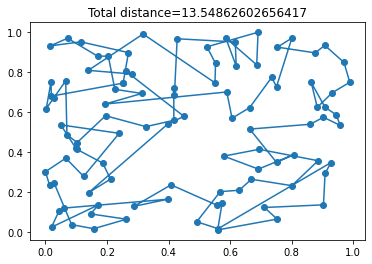

T=   0.05084 , distance=  13.54863 acc.steps=250


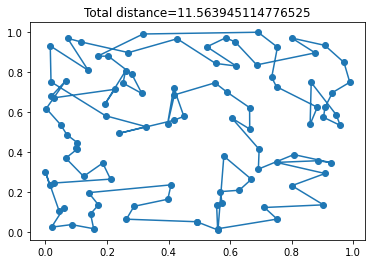

T=   0.04575 , distance=  11.56395 acc.steps=201


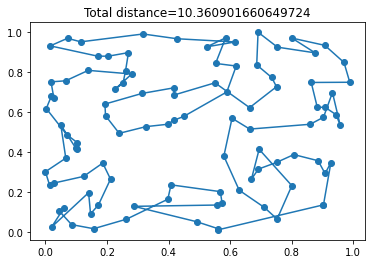

T=   0.04118 , distance=  10.36090 acc.steps=144


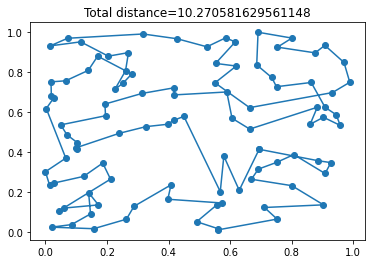

T=   0.03706 , distance=  10.27058 acc.steps=104


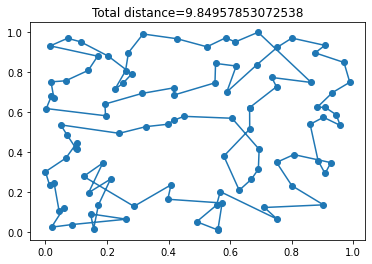

T=   0.03335 , distance=   9.84958 acc.steps=86


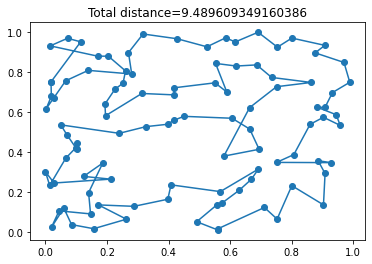

T=   0.03002 , distance=   9.48961 acc.steps=77


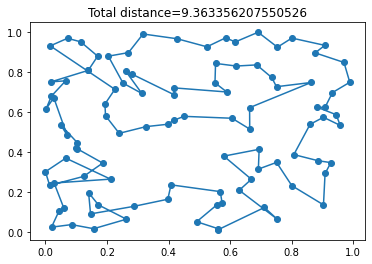

T=   0.02702 , distance=   9.36336 acc.steps=71


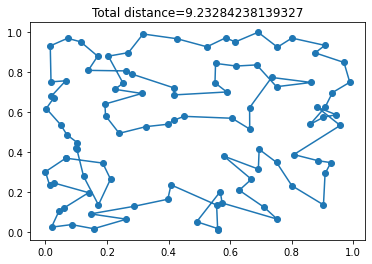

T=   0.02432 , distance=   9.23284 acc.steps=42


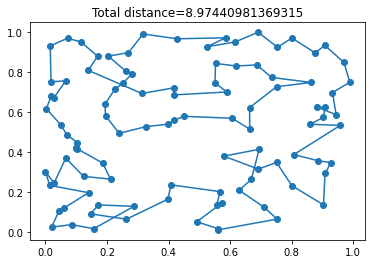

T=   0.02188 , distance=   8.97441 acc.steps=33


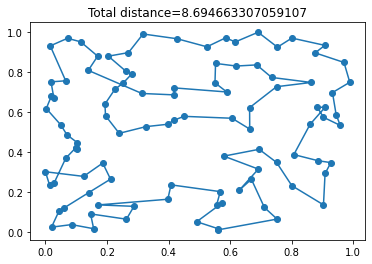

T=   0.01970 , distance=   8.69466 acc.steps=25


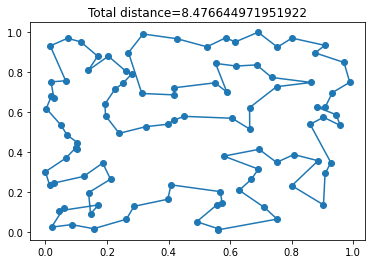

T=   0.01773 , distance=   8.47664 acc.steps=22


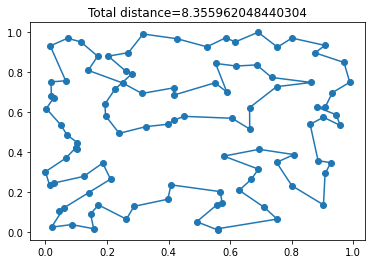

T=   0.01595 , distance=   8.35596 acc.steps=20


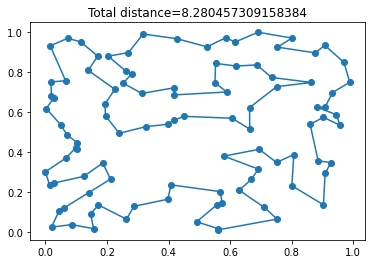

T=   0.01436 , distance=   8.28046 acc.steps=13


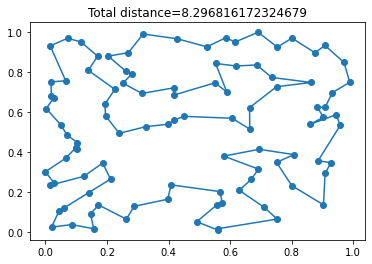

T=   0.01292 , distance=   8.29682 acc.steps=11


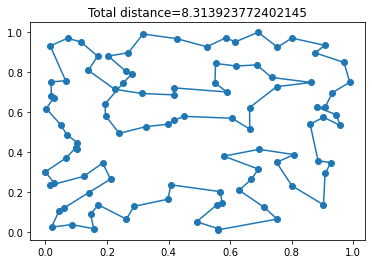

T=   0.01163 , distance=   8.31392 acc.steps=17


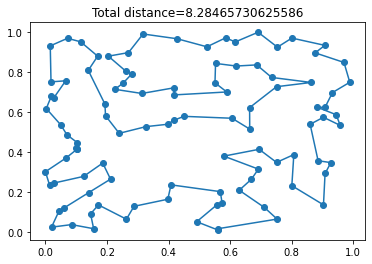

T=   0.01047 , distance=   8.28466 acc.steps=8


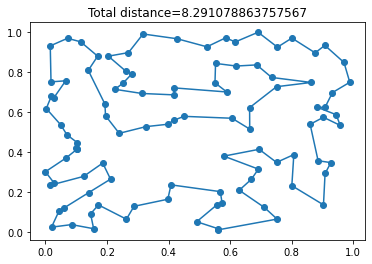

T=   0.00942 , distance=   8.29108 acc.steps=8


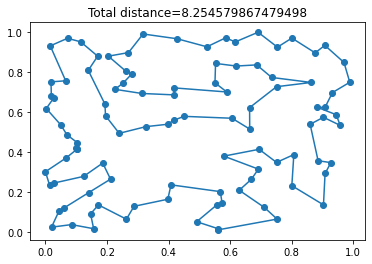

T=   0.00848 , distance=   8.25458 acc.steps=11


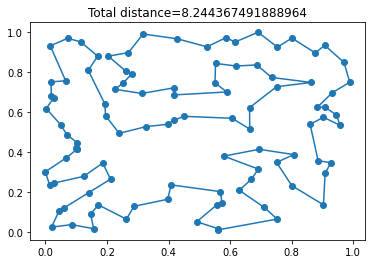

T=   0.00763 , distance=   8.24437 acc.steps=3


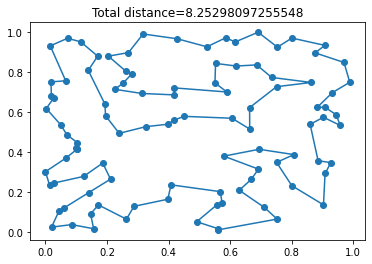

T=   0.00687 , distance=   8.25298 acc.steps=2


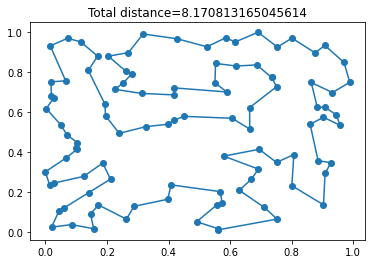

T=   0.00618 , distance=   8.17081 acc.steps=5


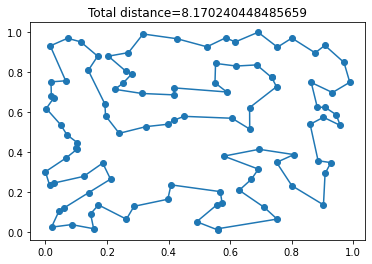

T=   0.00556 , distance=   8.17024 acc.steps=2


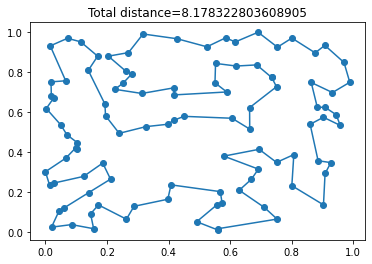

T=   0.00501 , distance=   8.17832 acc.steps=5


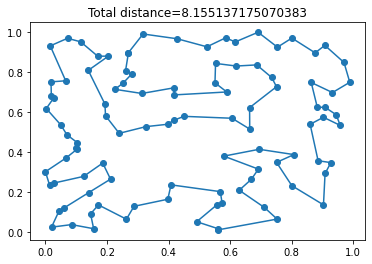

T=   0.00451 , distance=   8.15514 acc.steps=4


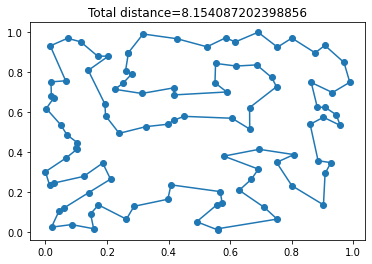

T=   0.00406 , distance=   8.15409 acc.steps=5


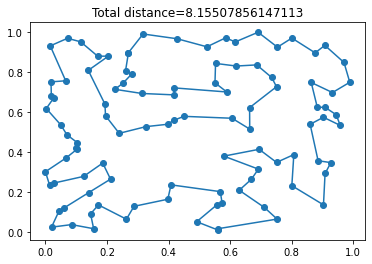

T=   0.00365 , distance=   8.15508 acc.steps=4


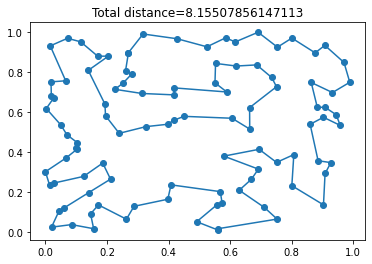

T=   0.00328 , distance=   8.15508 acc.steps=4


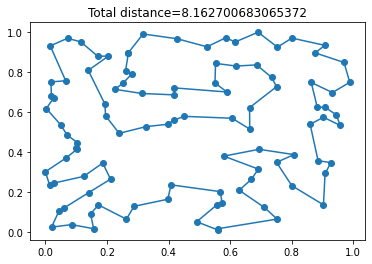

T=   0.00296 , distance=   8.16270 acc.steps=6


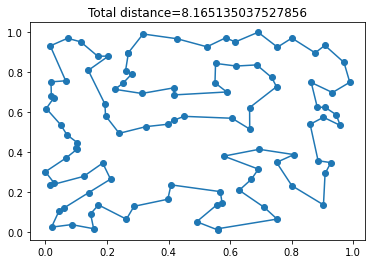

T=   0.00266 , distance=   8.16514 acc.steps=7


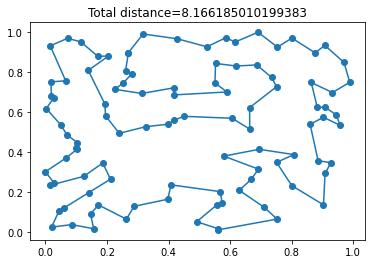

T=   0.00239 , distance=   8.16619 acc.steps=5


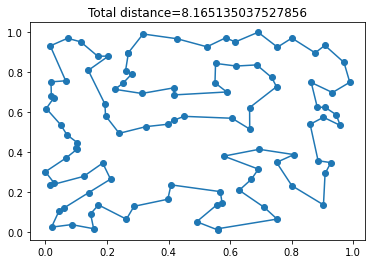

T=   0.00216 , distance=   8.16514 acc.steps=1


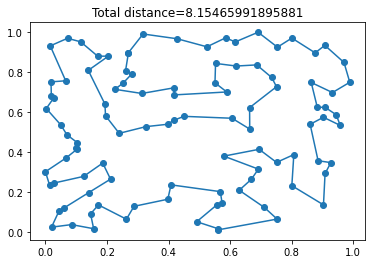

T=   0.00194 , distance=   8.15466 acc.steps=3


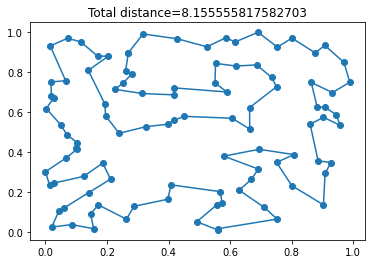

T=   0.00175 , distance=   8.15556 acc.steps=7


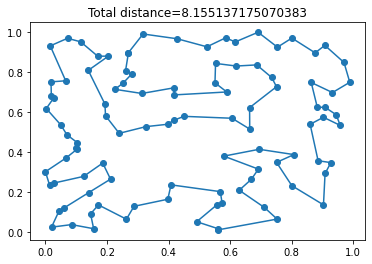

T=   0.00157 , distance=   8.15514 acc.steps=2


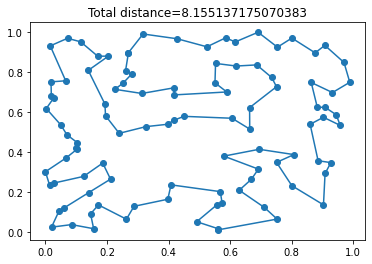

T=   0.00141 , distance=   8.15514 acc.steps=0


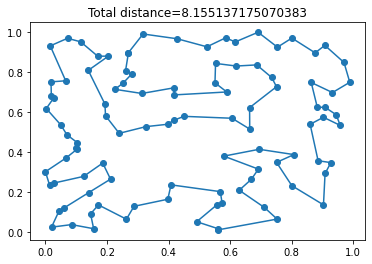

In [28]:
from numpy import random

ncity = 100
maxSteps = 100*ncity
maxAccepted = 10*ncity
Tstart = 0.2
fCool = 0.9
maxTsteps = 100

random.seed(1)

R = random.random((ncity,2))
city = range(ncity)

ncity = TravelingSalesman(city, R, maxSteps, maxAccepted, Tstart, fCool, maxTsteps)

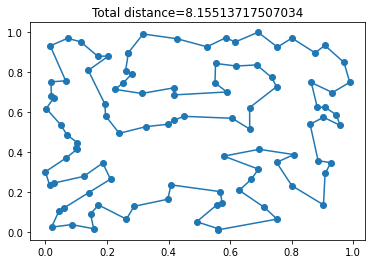

In [29]:
Plot(ncity,R, TotalDistance(ncity,R))

## Homework

1) Implement Traveling Salesman problem.

2) Test traveling salesman problem and plot distance $d$ versus $N$, where $N$ is number of cities. What is the optimal curve distance?